### Plate convergence

Our results suggest that there are a number of deformational modes of the model mantle lithosphere: 

- a dripping or Rayleigh-Taylor–type instability; 
- an asymmetric nderthrusting or subduction; 
- symmetric, ablative plate consumption; 
- slab breakoff, the failure and detachment of the strong lithosphere; and 
- mixed modes with combinations of these processes. 

The development of the modes is controlled by the rate of convergence associated with the background tectonic regime, the density field, and the rheology of the mantle lithosphere. 

<img src="F_Pysklywec2000_ModelSetup.png" alt="Drawing" style="width: 500px;"/> 

### Reference
- Pysklywec, R. N., Beaumont, C., & Fullsack, P. (2000). Modeling the behavior of the continental mantle lithosphere during plate convergence. Geology, 28(7), 655-658.

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis
import underworld as uw
from underworld import function as fn

import numpy as np
import math
u = GEO.UnitRegistry
GEO.__version__

loaded rc file /opt/venv/lib/python3.9/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


'2.12.1'

In [2]:
velocity = 1.5 * u.centimetre / u.year

# Scaling
T0 = 293.15 * u.degK # 20 * u.degC
Tz = 1733.15 * u.degK # 1500 * u.degC

K_viscosity = 1e20  * u.pascal * u.second
K_density = 3300 * u.kilogram / (u.meter)**3
KL = 2400 * u.kilometer
KH = 600 * u.kilometer
K_gravity =  10. * u.meter / u.second**2

Kt = KL /velocity
bodyforce = K_density  * K_gravity 
KM = bodyforce * KL**2 * Kt**2
KT = Tz - T0

GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[length]"] = KH
GEO.scaling_coefficients["[mass]"] = KM
GEO.scaling_coefficients["[temperature]"] = KT
    
GEO.rcParams["swarm.particles.per.cell.2D"]= 20    
# Model mesh
Model = GEO.Model(elementRes=(200,50),
                  minCoord=(0. * u.kilometer, -600. * u.kilometer),  
                  maxCoord=(2400 * u.kilometer,0. * u.kilometer ),
                  gravity=(0.0, -K_gravity))

Model.outputDir= "op_Pysklywec2010_uwg"
Model.minStrainRate = 1e-18 / u.second

resolution0 = 12.0 * u.kilometer

	Global element size: 200x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 200x50
In func WeightsCalculator_CalculateAll(): for swarm "1NGUHOQN__swarm"
	done 33% (3334 cells)...
	done 67% (6667 cells)...
	done 100% (10000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "1NGUHOQN__swarm"


In [3]:
D_crust = GEO.nd(-24 * u.kilometer)
D_ml = GEO.nd(-120* u.kilometer)
D_Bottom = GEO.nd(-KH)

SL_ws =  GEO.nd(12 * u.kilometer) 
X_ws0 = GEO.nd(1200 * u.kilometer) - SL_ws/2.
X_ws1 = GEO.nd(1200 * u.kilometer) + SL_ws/2. 
Y_ws0 = GEO.nd(-42 * u.kilometer) + SL_ws/2.
Y_ws1 = GEO.nd(-42 * u.kilometer) - SL_ws/2. 

crust       = Model.add_material(name="Crust", shape=GEO.shapes.Layer2D(top=Model.top, bottom=D_crust))
ml = Model.add_material(name="Mantle lithosphere0", shape=GEO.shapes.Layer2D(top=D_crust, bottom=D_ml))
ma = Model.add_material(name="Asthenosphere", shape=GEO.shapes.Layer2D(top=D_ml, bottom=Model.bottom))
weakseed = Model.add_material(name="Week seed", shape=GEO.shapes.Box(Y_ws0, Y_ws1, minX=X_ws0, maxX=X_ws1))

In [4]:
npoints = 250
coords0 = np.ndarray((npoints, 2))
coords0[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords0[:, 1] = D_crust

coords1 = np.ndarray((npoints, 2))
coords1[:, 0] = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
coords1[:, 1] = D_ml

Model.add_passive_tracers(name="interface0", vertices=coords0)
Model.add_passive_tracers(name="interface1", vertices=coords1)


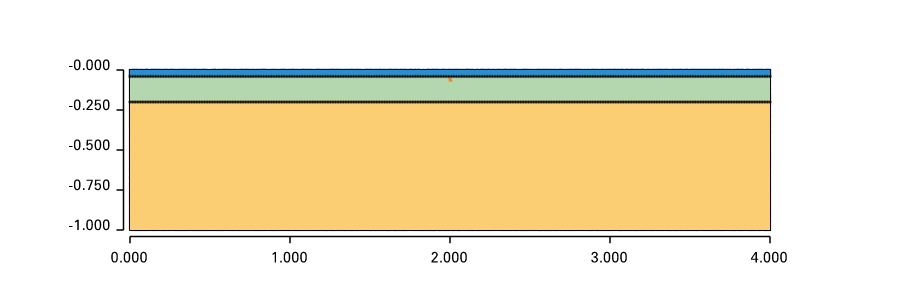

In [5]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70)
Fig.Points(Model.interface0_tracers, pointSize=4.0)
Fig.Points(Model.interface1_tracers, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.show()

In [6]:
rh = GEO.ViscousCreepRegistry()

In [7]:
rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995

In [8]:
# Viscous rheology
Model.maxViscosity = 1e24 * u.pascal * u.second
Model.minViscosity = 1e18 * u.pascal * u.second

Dry_Olivine_Chopra1984= GEO.ViscousCreep(name='Dry Olivine_Chopra and Paterson 1984',
                                 preExponentialFactor=5.495e-25/(u.pascal ** 4.48)/u.second,
                                 stressExponent=4.48, activationEnergy=498 * u.kilojoules/u.mole,
                                 f=1.0)  

crust.viscosity    = 0.25*rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
weakseed.viscosity = Dry_Olivine_Chopra1984
ml.viscosity      = Dry_Olivine_Chopra1984
ma.viscosity      = Dry_Olivine_Chopra1984

# Plastic rheology
frictionC1 = np.tan(np.radians(15.0))
frictionC2 = np.tan(np.radians(2.0))
plasticity0 = GEO.DruckerPrager(name="Von Mises",cohesion=10.0 * u.megapascal,
                               cohesionAfterSoftening=10.0 * u.megapascal,
                               frictionCoefficient = frictionC1, frictionAfterSoftening = frictionC1,
                               epsilon1=0.5,
                               epsilon2=1.5)
plasticity1 = GEO.DruckerPrager(name="Von Mises",cohesion=100.0 * u.megapascal,
                               cohesionAfterSoftening=10.0 * u.megapascal,
                               frictionCoefficient = frictionC1, frictionAfterSoftening = frictionC2,
                                epsilon1=0.5,
                               epsilon2=1.5)

weakseed.plasticity = plasticity0
crust.plasticity    = plasticity0
ml.plasticity      = plasticity1
ma.plasticity      = plasticity1

# Density (Pysklywec2002)
r_tE0 = 3e-5 / u.kelvin
r_tE1 = 2e-5 / u.kelvin
r_tem0 = 500.0 * u.degK
r_tem1 = 750.0 * u.degK
# r_beta = 1.0e-11 / u.pascal 
# r_pre =  0.24e6 * u.pascal

crust.density = GEO.LinearDensity(2800. * u.kilogram / u.metre**3,thermalExpansivity = r_tE0,
                                reference_temperature = r_tem0)                                                     
ml.density   = GEO.LinearDensity(3300. * u.kilogram / u.metre**3,thermalExpansivity = r_tE1,
                                reference_temperature = r_tem1)     
ma.density    = GEO.LinearDensity(3300. * u.kilogram / u.metre**3,thermalExpansivity = r_tE1,
                                reference_temperature = r_tem1)     
weakseed.density = GEO.LinearDensity(3300. * u.kilogram / u.metre**3,thermalExpansivity = r_tE1,
                                reference_temperature = r_tem1)  
# crust.density    = 2800. * u.kilogram / u.metre**3
# ml0.density      = 3300. * u.kilogram / u.metre**3
# ma.density       = 3260. * u.kilogram / u.metre**3

#Thermol
Model.capacity = 750. * u.joule / (u.kelvin * u.kilogram)
crust.capacity = 750. * u.joule / (u.kelvin * u.kilogram)
ml.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)
ma.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)
weakseed.capacity    = 750. * u.joule / (u.kelvin * u.kilogram)

Model.diffusivity = 1.0e-6 * u.metre**2 / u.second 
crust.diffusivity = 1.0e-6 * u.metre**2 / u.second 
ml.diffusivity = 1.0e-6 * u.metre**2 / u.second 
ma.diffusivity = 1.0e-6 * u.metre**2 / u.second 
weakseed.diffusivity = 1.0e-6 * u.metre**2 / u.second 

In [9]:
Vx  = GEO.nd(velocity)
Vxb = np.abs(-Vx *D_ml/2/(-D_Bottom-D_ml))

conditions0 = [(Model.y >= D_ml, GEO.nd(0.0 * u.centimetre/u.year)),
            (True, -Vxb)]
function0 = fn.branching.conditional(conditions0)

conditions1 = [(Model.y > D_ml, -Vx),
               (Model.y == D_ml, GEO.nd(0.0 * u.centimetre/u.year)),
              (True, Vxb)]
function1 = fn.branching.conditional(conditions1)

Model.set_velocityBCs(left=[function0, None],
                      right=[function1, None],
                      bottom=[None, 0.],
                      top=[None,None],
                      order_wall_conditions=[ "left", "right","top", "bottom"])

surface_nodes = GEO.shapes.Layer2D(top=0.+resolution0/4, bottom=0.-resolution0/4)

Model.set_temperatureBCs(top=T0 ,
                         bottom=Tz,nodeSets=[(surface_nodes,T0)])

In [10]:
T0 = 293.15 * u.degK
T1 = 693.15 * u.degK
T2 = 1623.15 * u.degK
Tz = 1773.15 * u.degK 

crust_geotherm        = GEO.nd(T0) + GEO.nd(T1-T0)*(Model.y)/D_crust
lithosphere_geotherm  = GEO.nd(T1) + GEO.nd(T2-T1)*(Model.y -D_crust)/(D_ml-D_crust)
mantle_geotherm       = GEO.nd(T2) + GEO.nd(Tz-T2)*(Model.y - D_ml)/(D_Bottom-D_ml)

geotherm_fn = fn.branching.conditional([(Model.y >= D_crust,crust_geotherm),
                                        (Model.y >= D_ml,lithosphere_geotherm),
                                        (True, mantle_geotherm)])

Model.init_model(temperature=geotherm_fn)
Model.init_model(pressure="lithostatic",temperature=False)

Q82F5KCG__cm


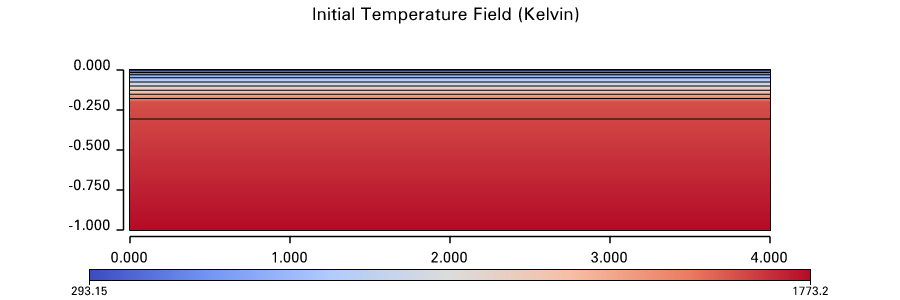

In [11]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
#Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True)
# Fig.Points(surf_tracers, pointSize=4.0)
# Fig.Points(moho_tracers, pointSize=4.0)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.Contours(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), interval= 150, limits=(293.15,1773.15),colours='Black', colourBar=False)
Fig.show()


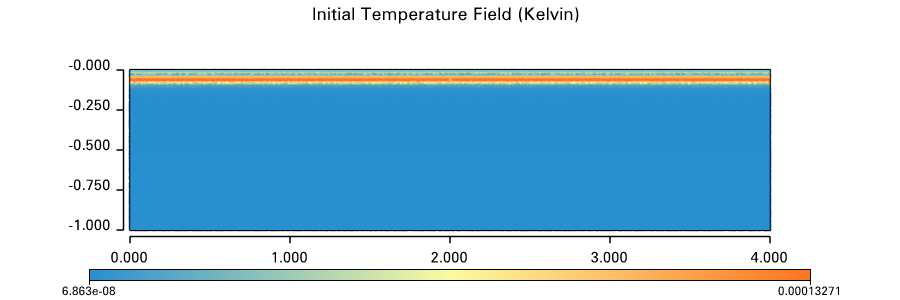

In [12]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
Fig.Points(Model.swarm,Model.viscosityField,pointSize=4.0,colourBar = True)#colours="jet" ,
Fig.show()

In [13]:
Model.freeSurface = True
#Model.fssa_factor = 1.0

	Global element size: 200x50
	Local offset of rank 0: 0x0
	Local range of rank 0: 200x50


In [ ]:
Model.solver.set_inner_method("mumps")
#Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 5e-2

outputss=['pressureField',
         'strainRateField',
         'velocityField',
          'projTimeField',
           'projMaterialField',
         'projViscosityField',
         'projStressField',
         'projDensityField',
         'projStressTensor',]
GEO.rcParams['default.outputs']=outputss

In [ ]:
# checkpoint_interval = 0.005*u.megayears

# def plot_fig():
#     global FigMat
#     if GEO.nd(Model.time)%GEO.nd(checkpoint_interval)==0:
#     #if GEO.nd(Model.step)%GEO.nd(checkpoint_interval)==0:
        
        
# #         K_L = 192e3
# #         x,y = surftracer.data[:,0]*K_L/1000,Model.surface_tracers.data[:,1]*K_L/1000
# #         fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
# #         ax1.set(xlabel='Distance [km]', ylabel='Topo [km]')
# #         ax1.plot(x,y,'k')
# #         ax1.set_ylim([-2,10])
# #         ax1.set_xlim([0,192])
# #         ax1.grid()
# #         plt.savefig(Model.outputDir+"/Topo-{0}.png".format(Model.checkpointID))
# #         plt.close()
                         
#         Fig = vis.Figure(resolution=(800,400),rulers=True)
#         Fig.Points(Model.interface0_tracers, pointSize=4.0)
#         Fig.Points(Model.interface1_tracers, pointSize=4.0)
#         Fig.Points(Model.interface2_tracers, pointSize=4.0)
#         Fig.Points(Model.swarm, Model.materialField,fn_size=4.0,discrete=True,colourBar=False)
#         #Fig.show()
#         Fig.save(Model.outputDir+"/Material-{0}.png".format(Model.checkpointID))
# Model.post_solve_functions["plot_fig"] = plot_fig

In [ ]:
#Model.run_for(nstep=10, checkpoint_interval=1)#,dt=0.01*u.megayears)
#Model.run_for(1.6 * u.megayears, checkpoint_interval=checkpoint_interval,dt=checkpoint_interval)

In [ ]:
Model.run_for(1.6 * u.megayears, checkpoint_interval=0.1*u.megayears,dt=1000*u.year)
#Model.run_for(6.4 * u.megayears, checkpoint_interval=0.1*u.megayears,dt=2500*u.year)
#Model.run_for(5.5 * u.megayears, checkpoint_interval=100000*u.year,dt=5000*u.year)

In [ ]:
Fig = vis.Figure(resolution=(900,300),rulers=True,margin = 70,title="Initial Temperature Field (Kelvin)")
Fig.Points(Model.swarm,Model.viscosityField,pointSize=4.0,colourBar = True)#colours="jet" ,
Fig.show()